# Data Processing and Representation - HW 1 - Implementation

In [45]:
import matplotlib.pyplot as plt
import imageio
import os
import cv2
import numpy as np
from skimage import io, color
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import pandas as pd

## Question 1 - Quantization

### Section 1 - Histogram out of an image

In [46]:
image_orig = cv2.imread("lion.jpg", cv2.IMREAD_UNCHANGED)

In [47]:
def turn_image_grey(image):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey_image_arr = np.array(grey_image, dtype=np.uint)
    return grey_image_arr

In [48]:
grey_image_array = turn_image_grey(image_orig)

In [49]:
def show_image(image):
  grey_image = turn_image_grey(image)
  plt.imshow(grey_image, cmap='gray', vmin=grey_image.min(), vmax=grey_image.max())
  plt.show()

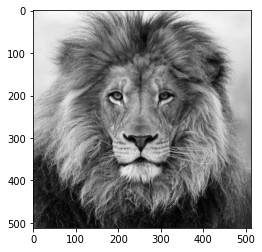

In [50]:
show_image(image_orig)

In [51]:
def get_image_hist(image):
  return np.histogram(image, bins= range(0,257))

In [52]:
# for future use:
hist = get_image_hist(grey_image_array)[0]

In [53]:
def show_image_hist(image):
    plt.figure(1)
    plt.clf()
    plt.title("Grey Image Histogram")
    hist = get_image_hist(image)
    _ = plt.plot(hist[1][:-1], hist[0], lw=2)
    plt.grid()


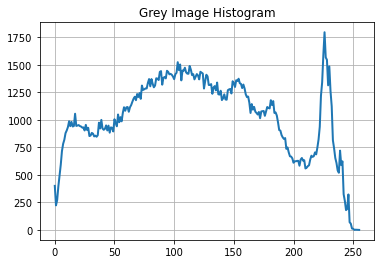

In [54]:
show_image_hist(grey_image_array)

### Section 2 - Uniform Quantization

In [55]:
def image_uniform_quantization(grey_image_array, b) :
  # find the representatives as we saw in the lecture (unifomr case):

  # first separate the values range to 2^b intervals:
  Delta = (grey_image_array.max() - grey_image_array.min())/(2**b)

  # calculate the representative interval entry for each value of grey_image_array:
  interval_entries_array = np.floor((grey_image_array - grey_image_array.min())/Delta)

  # in each interval, find representative quantizer:
  quantized_image_array = grey_image_array.min() + (interval_entries_array+0.5)*Delta

  return quantized_image_array

MSE function per b:

In [56]:
def find_MSE_per_b(grey_image_array, b):
  mse_array = np.zeros(b+1, dtype=np.float64)
  for i in range(1,9) :
    # as we saw in class, the MSE formula:
    mse_array[i] = np.mean((grey_image_array - image_uniform_quantization(grey_image_array, i))**2)
  return mse_array[1:]

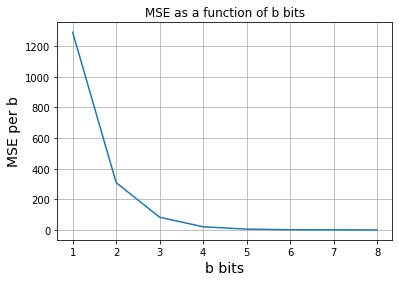

In [57]:
MSE_uniform = find_MSE_per_b(grey_image_array, 8)
plt.plot(range(1,9), MSE_uniform)
plt.title("MSE as a function of b bits")
plt.xlabel("b bits", fontsize = 14)
_ = plt.ylabel("MSE per b", fontsize = 14)
plt.grid()

Decision and Represenation levels per b

In [58]:
def get_decision_and_representation_levels_per_b(grey_image_array, b):
  # init interval length and arrays:
  Delta = (grey_image_array.max() - grey_image_array.min())/(2**b)
  decision_levels = np.zeros(2**b+1, dtype=np.float64)
  representation_levels = np.zeros(2**b, dtype=np.uint)

  # calculate each array values according to the lecture:
  for i in range(0, 2**b+1) :
    decision_levels[i] = grey_image_array.min() + i*Delta

  for i in range(0, 2**b) :
    representation_levels[i] = grey_image_array.min() + (i+0.5)*Delta

  return decision_levels, representation_levels

Plot decision and representation levels per b

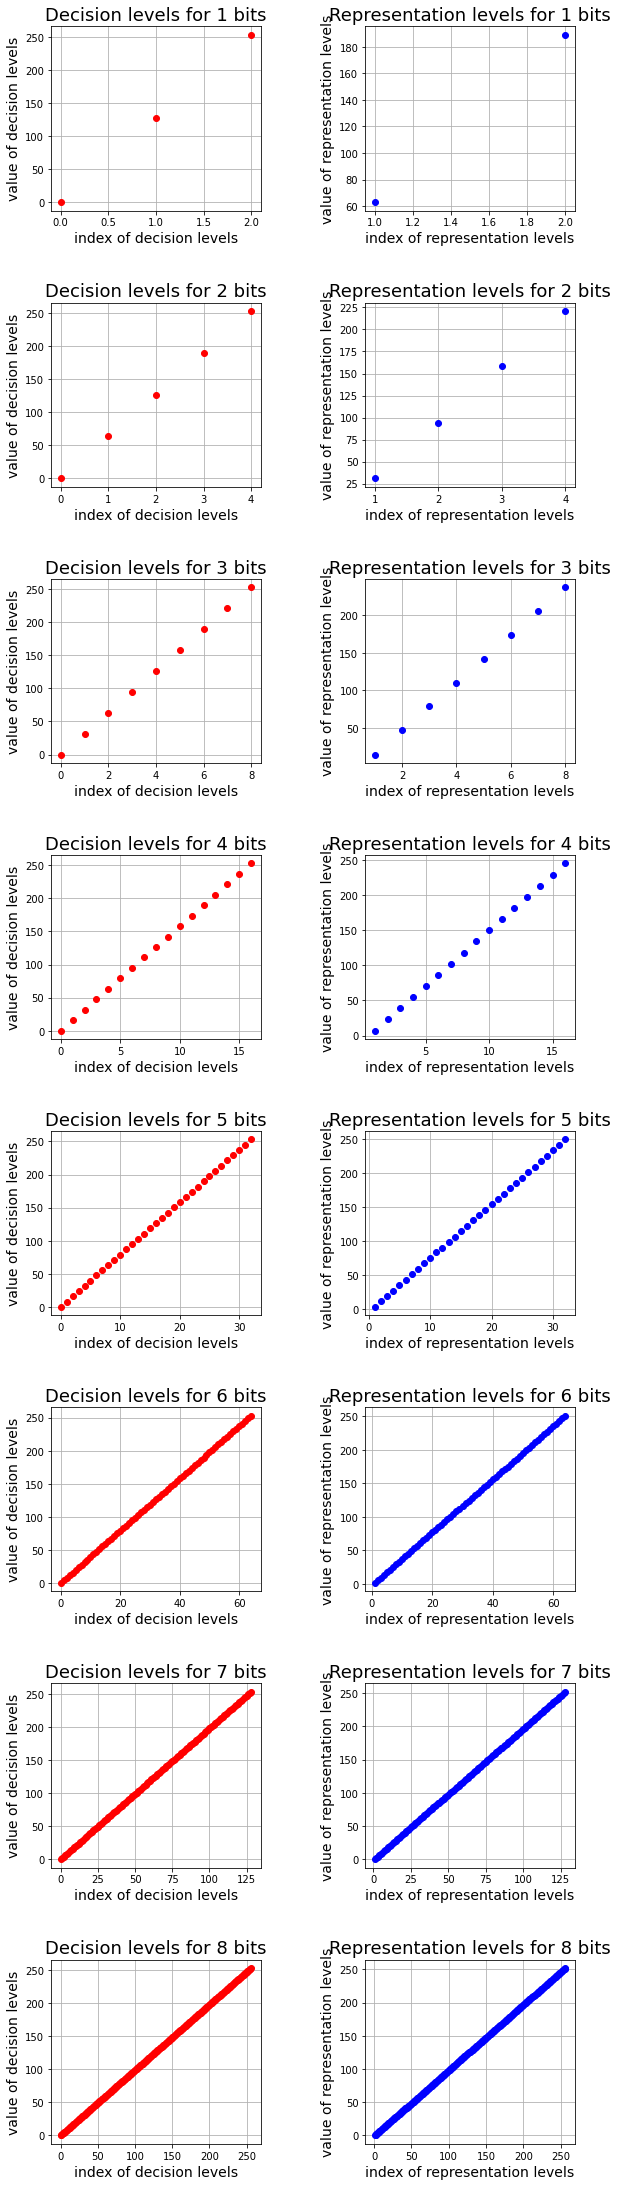

In [59]:
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
# fig = plt.figure()
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for b in range(1,9):
  decision_levels , representation_levels = get_decision_and_representation_levels_per_b(grey_image_array, b)
  
  #plot decision levels:
  # ax[b-1,0] = fig.add_subplot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 18)
  ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
  ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
  ax[b-1,0].grid()
  # ax.show()

  #plot representation levels:
  # ax[b-1,1] = fig.add_subplot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,1].plot(range(1,(2**b)+1), representation_levels, "bo")
  ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 18)
  ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
  ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
  ax[b-1,1].grid()
# _ = plt.show()

Given the decision regions, the best representation levels are the centers of mass of the regions

### Section 3 - Max-Lloyd implementation

Utility function for Max-Lloyd to calculate represantation levels

In [60]:
def calculate_representation_levels(hist, decision_levels):
  px = hist/hist.sum()
  xpx = np.array([x*px[x] for x in range(0,px.size)])
  representation_levels = np.zeros(decision_levels.size-1, dtype=int)
  # as we saw in the lacture:
  for i in range(0,representation_levels.size):
    lower_interval_boundry = int(np.ceil(decision_levels[i]))
    upper_interval_boundry = int(np.ceil(decision_levels[i+1]))
    integral_xpx = np.sum(xpx[lower_interval_boundry:upper_interval_boundry])
    integral_px  =np.sum(px[lower_interval_boundry:upper_interval_boundry])
    if integral_xpx==0 or integral_px==0:
      # this means the distribution in this interval is uniform,
      # so the representative will be the middle of the interval:
      representation_levels[i] = (int(decision_levels[i]+decision_levels[i+1]))/2
    else:
      representation_levels[i] = integral_xpx / integral_px
  return representation_levels

Utility function for Max-Lloyd to calculate decision levels.

Given the representation levels, the best decision levels are in the middle between the representation levels

In [61]:
def calculate_decision_levels(representation_levels, decision_levels):
  # as we saw in the lacture:
  for i in range(1,decision_levels.size-1): # the first and last decision levels remain the same
    decision_levels[i] = (representation_levels[i-1]+representation_levels[i])/2
  return decision_levels

Calculate MSE w.r.t decision levels and representation levels

In [62]:
def calculate_MSE(hist, representation_levels, num_of_samples):
  MSE = 0
  for x in range(0,hist.size):
    # for each x (color) in the image, find the representative by
    # subtracting x from the representatives array and find he closest
    # by taking the min difference (squarred):
    color_squarred_error = ((representation_levels-x)**2).min()
    MSE += hist[x]*color_squarred_error
  MSE /= num_of_samples
  return MSE

MAX-LOYD implementation

In [63]:
def MaxLoyd(hist, decision_levels, epsilon=0.005):
  num_of_samples = np.sum(hist)
  representation_levels=calculate_representation_levels(hist,decision_levels)
  prev_MSE = calculate_MSE(hist, representation_levels, num_of_samples)
  while True:
    decision_levels=calculate_decision_levels(representation_levels, decision_levels)
    representation_levels=calculate_representation_levels(hist,decision_levels)
    curr_MSE = calculate_MSE(hist, representation_levels, num_of_samples)
    if np.abs(curr_MSE - prev_MSE) < epsilon:
      return decision_levels, representation_levels, curr_MSE
    prev_MSE = curr_MSE

### Apply MAX-LOYD quantizer upon our image per b bits and plot MSE values for each

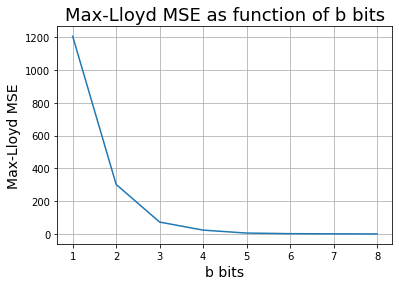

In [64]:
MSE_Max_Lloyd = np.zeros(9, dtype=np.float64)
for b in range(1,9) :
  decision, _ = get_decision_and_representation_levels_per_b(grey_image_array,b)
  decision, representation, MSE = MaxLoyd(hist, decision)
  MSE_Max_Lloyd[b] = MSE
plt.plot(range(1,9), MSE_Max_Lloyd[1:])
plt.title("Max-Lloyd MSE as function of b bits", fontsize=18)
plt.xlabel("b bits", fontsize=14)
_ = plt.ylabel("Max-Lloyd MSE", fontsize=14)
plt.grid()

Apply MAX-LOYD algorithm upon our image per b bits and plot decision levels and representation levels for each

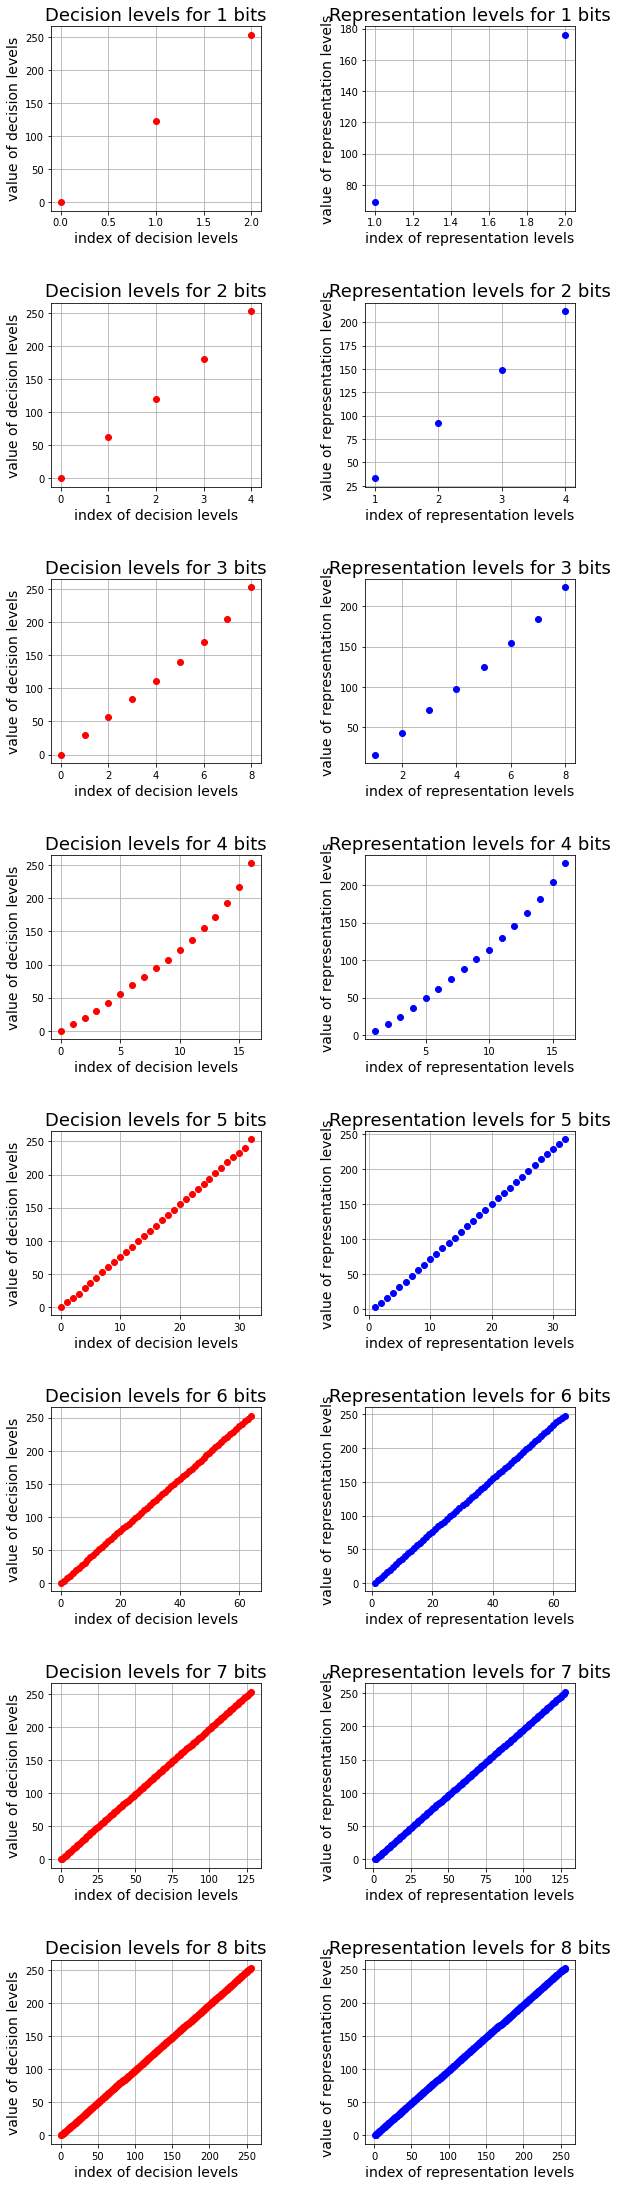

In [65]:
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
# fig = plt.figure()
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for b in range(1,9):
  decision_levels , _ = get_decision_and_representation_levels_per_b(grey_image_array, b)
  decision_levels, representation_levels, _ = MaxLoyd(hist, decision_levels) 

  #plot decision levels:
  # ax[b-1,0] = fig.add_subplot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 18)
  ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
  ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
  ax[b-1,0].grid()
  # ax.show()

  #plot representation levels:
  # ax[b-1,1] = fig.add_subplot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,1].plot(range(1,(2**b)+1), representation_levels, "bo")
  ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 18)
  ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
  ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
  ax[b-1,1].grid()

Compare MaxLoys results to uniform quantizer

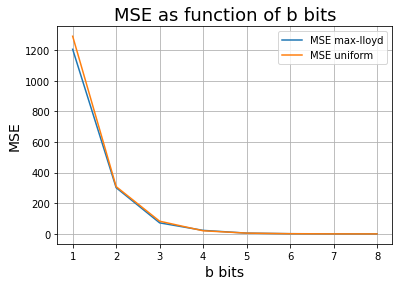

In [66]:
max_loyd_plot, = plt.plot(range(1,9), MSE_Max_Lloyd[1:], label='MSE max-lloyd')
uniform_plot, = plt.plot(range(1,9), MSE_uniform, label='MSE uniform')
plt.title("MSE as function of b bits", fontsize=18)
plt.xlabel("b bits", fontsize = 14)
plt.grid()
_ = plt.ylabel("MSE", fontsize = 14)
plt.legend(handles = [max_loyd_plot, uniform_plot])
plt.show()

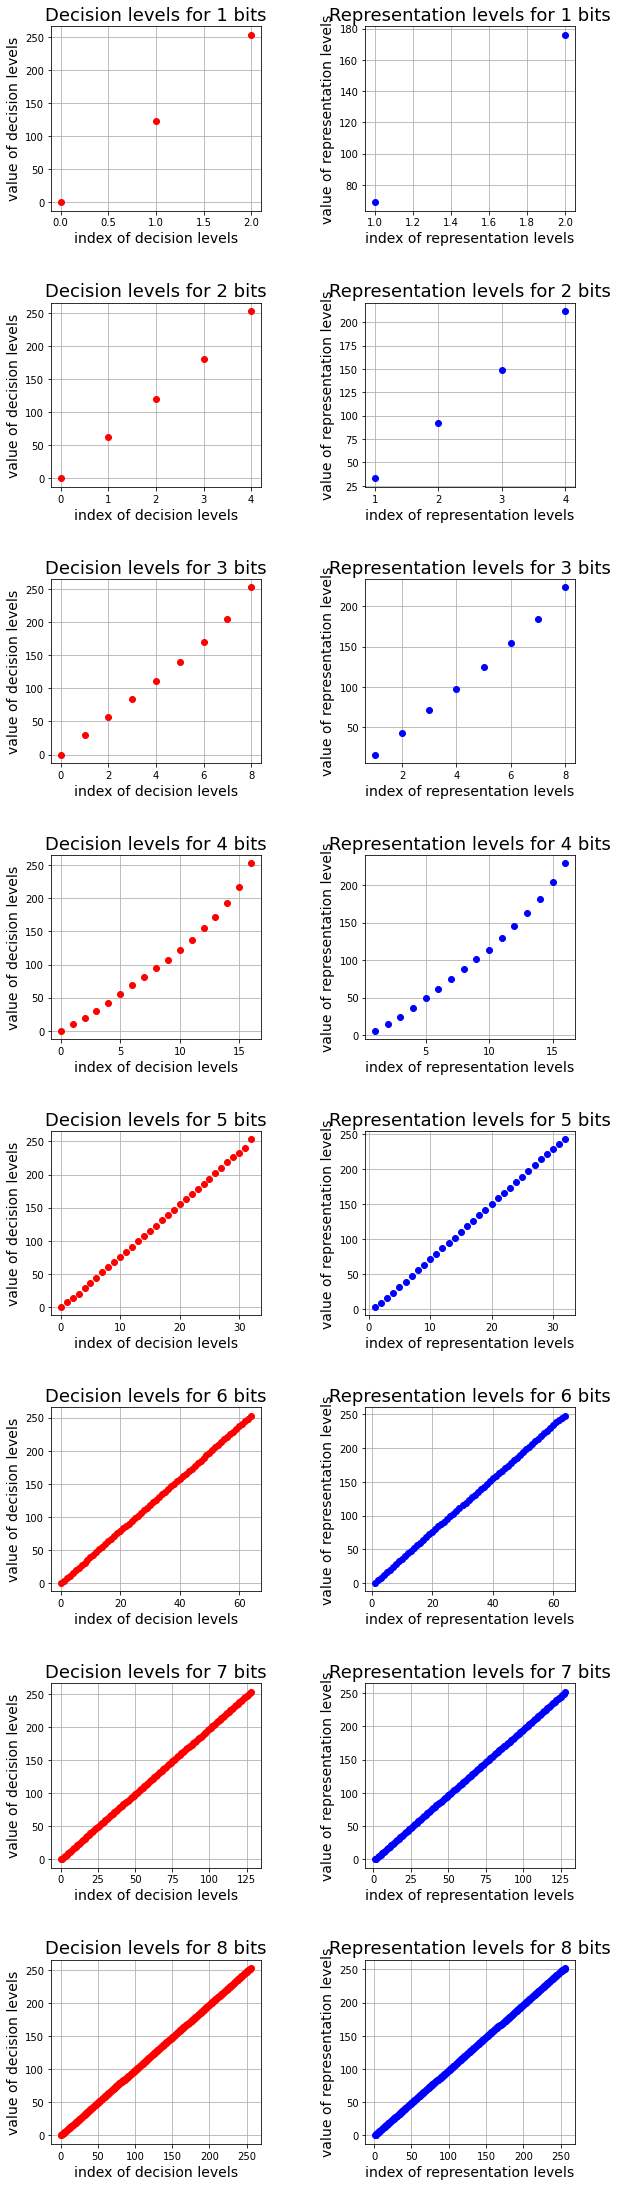

In [67]:
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
# fig = plt.figure()
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)


for b in range(1,9):
  decision_levels , _ = get_decision_and_representation_levels_per_b(grey_image_array, b)
  decision_levels, representation_levels, _ = MaxLoyd(hist, decision_levels) 

  #plot decision levels:
  # ax[b-1,0] = fig.add_subplot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 18)
  ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
  ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
  ax[b-1,0].grid()
  # ax.show()

  #plot representation levels:
  # ax[b-1,1] = fig.add_subplot(range(0,(2**b)+1), decision_levels, "ro")
  ax[b-1,1].plot(range(1,(2**b)+1), representation_levels, "bo")
  ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 18)
  ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
  ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
  ax[b-1,1].grid()

## Question 2 : subsampling and reconstruction

In [68]:
def grid_image_by_mean(grey_image, D):
  grid_grey_image = np.zeros((D,D))
  grid_length = grey_image.shape[0]//D
  for i in range(0,D):
    for j in range(0,D):
      grid_grey_image[i][j] = int(np.mean(grey_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length])+0.5)
  return grid_grey_image

def form_reconstruction(grid_grey_image, shape_image_orig):
  reconstructed_image = np.zeros((shape_image_orig,shape_image_orig))
  grid_length = shape_image_orig//grid_grey_image.shape[0]
  for i in range(0,grid_grey_image.shape[0]):
    for j in range(0,grid_grey_image.shape[0]):
      reconstructed_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length]= grid_grey_image[i][j]
  return reconstructed_image

### MSE subsample and reconstrcuted

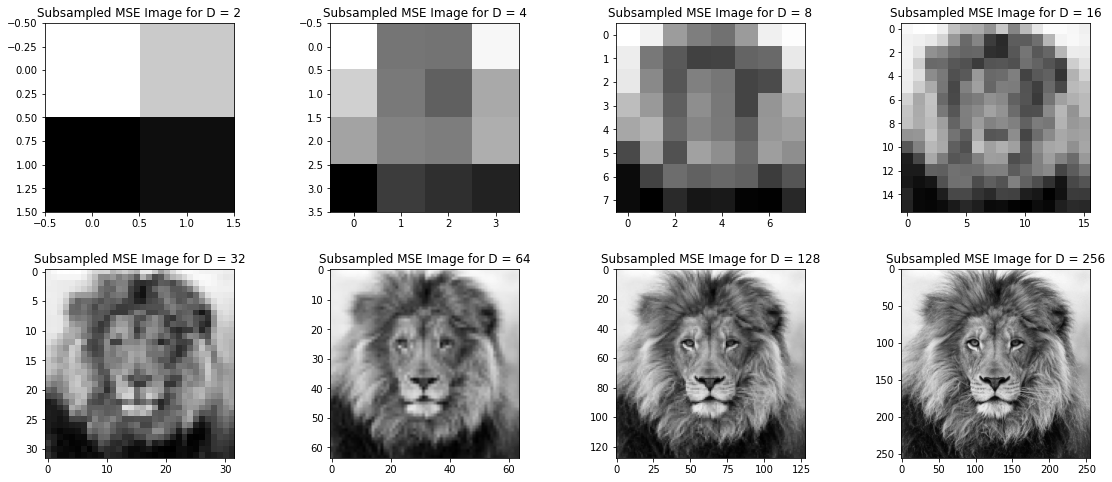

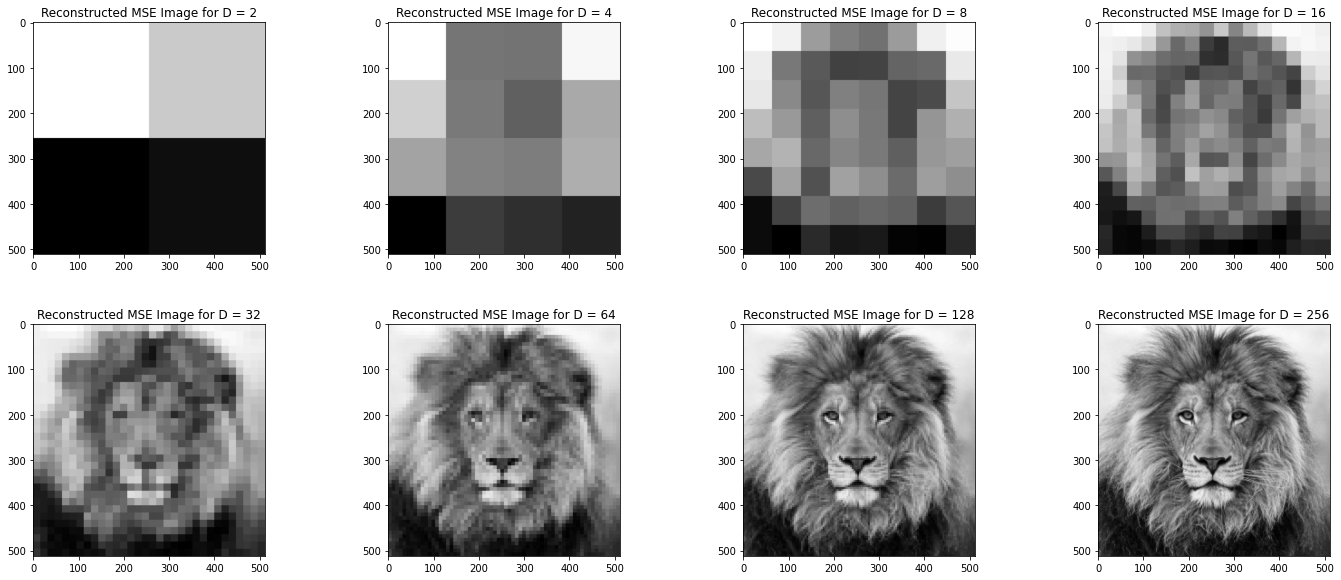

In [69]:
arab_dict = {0:0,1:0,2:0,3:0, 4:1,5:1,6:1,7:1}
fig_subsamples, ax_subsamples = plt.subplots(2, 4, figsize=(20, 8))
fig_reconstructed, ax_reconstructed = plt.subplots(2, 4, figsize=(20, 8))

# fig = plt.figure()
plt.tight_layout()
fig_subsamples.subplots_adjust(hspace=0.3, wspace=0.1)
fig_reconstructed.subplots_adjust(hspace=0.3, wspace=0.1)

MSE_array = np.zeros(8, dtype=np.float64)
for b in range(0,8):
  grided_image_by_mean = grid_image_by_mean(grey_image_array, 2**(b+1))
  reconstructed_image_by_mean = form_reconstruction(grided_image_by_mean, grey_image_array.shape[0])
  # as we saw in the lecture:
  MSE_array[b] = np.mean((grey_image_array - reconstructed_image_by_mean)**2)

  # add the MSE by current D 
  ax_subsamples[arab_dict[b],b%4].set_title("Subsampled MSE Image for D = "+str(2**(b+1)))
  ax_subsamples[arab_dict[b],b%4].imshow(grided_image_by_mean, cmap='gray', vmin=grided_image_by_mean.min(), vmax=grided_image_by_mean.max())
  # plt.show()

  ax_reconstructed[arab_dict[b],b%4].set_title("Reconstructed MSE Image for D = "+str(2**(b+1)))
  ax_reconstructed[arab_dict[b],b%4].imshow(reconstructed_image_by_mean, cmap='gray', vmin=reconstructed_image_by_mean.min(), vmax=reconstructed_image_by_mean.max())
  # _ = plt.show()


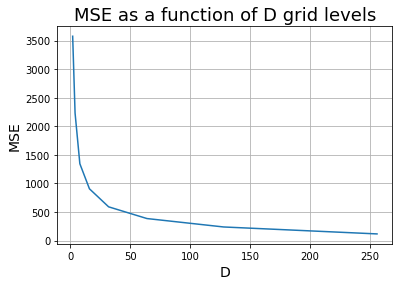

In [70]:
# MSE
plt.plot(np.logspace(1,8,8,base=2), MSE_array)
plt.title("MSE as a function of D grid levels", fontsize=18)
plt.xlabel("D", fontsize = 14)
plt.grid()
_ = plt.ylabel("MSE", fontsize = 14)

### MAD subsample and reconstrcuted

In [71]:
def grid_image_by_median(grey_image, D):
  grid_grey_image = np.zeros((D,D))
  grid_length = grey_image.shape[0]//D
  for i in range(0,D):
    for j in range(0,D):
      grid_grey_image[i][j]= int(np.median(grey_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length])+0.5)
  return grid_grey_image

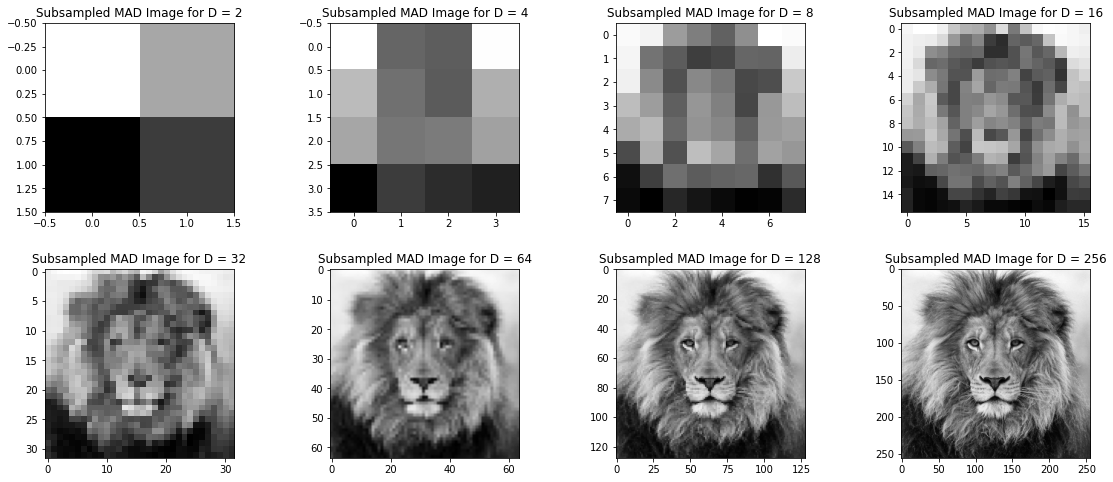

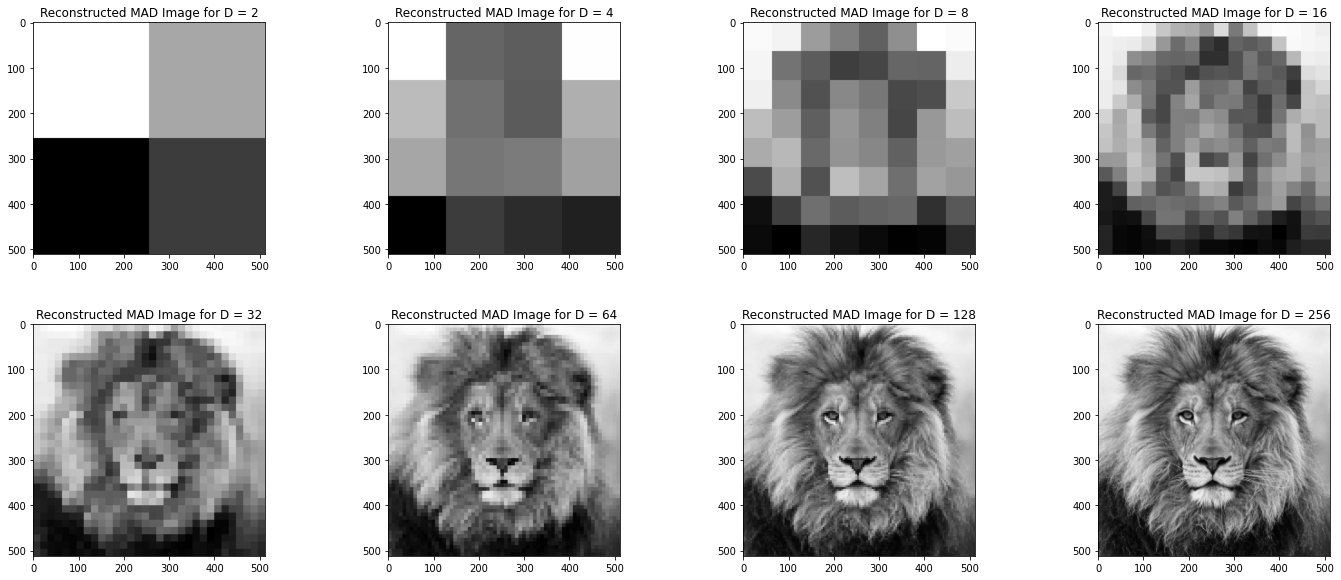

In [72]:
fig_subsamples, ax_subsamples = plt.subplots(2, 4, figsize=(20, 8))
fig_reconstructed, ax_reconstructed = plt.subplots(2, 4, figsize=(20, 8))

# fig = plt.figure()
plt.tight_layout()
fig_subsamples.subplots_adjust(hspace=0.3, wspace=0.1)
fig_reconstructed.subplots_adjust(hspace=0.3, wspace=0.1)

MAD_array = np.zeros(8, dtype=np.float64)
for b in range(0,8):
  grided_image_by_median = grid_image_by_median(grey_image_array, 2**(b+1))
  reconstructed_image_by_median = form_reconstruction(grided_image_by_median, grey_image_array.shape[0])
  # as we saw in the lecture:
  MAD_array[b] = np.mean((grey_image_array - reconstructed_image_by_median)**2)

  # add the MSE by current D 
  ax_subsamples[arab_dict[b],b%4].set_title("Subsampled MAD Image for D = "+str(2**(b+1)))
  ax_subsamples[arab_dict[b],b%4].imshow(grided_image_by_median, cmap='gray', vmin=grided_image_by_median.min(), vmax=grided_image_by_median.max())
  # plt.show()

  ax_reconstructed[arab_dict[b],b%4].set_title("Reconstructed MAD Image for D = "+str(2**(b+1)))
  ax_reconstructed[arab_dict[b],b%4].imshow(reconstructed_image_by_median, cmap='gray', vmin=reconstructed_image_by_median.min(), vmax=reconstructed_image_by_median.max())
  # _ = plt.show()


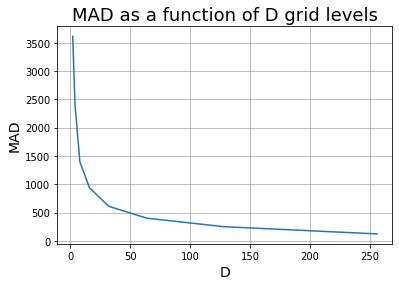

In [73]:
# MAD
plt.plot(np.logspace(1,8,8,base=2), MAD_array)
plt.title("MAD as a function of D grid levels", fontsize=18)
plt.xlabel("D", fontsize = 14)
plt.grid()
_ = plt.ylabel("MAD", fontsize = 14)

## Question 3: Solving the $L_p$ problem using the $L_2$ solution

### Section 2: $L_P$ solver implementation

In [74]:
def Lp_solver(grey_image, N, p, epsilon, delta):
  quantized_image = np.zeros((N,N), dtype=np.float64)
  grid_length = grey_image.shape[0]//N
  # at first, the quantizers of each block are all zero, so grey-image-arr(0)=grey_image
  # we calculate the error of the feirst round quantzers (zeros):
  Lp_error_prev =  np.mean((grey_image)**p)
  #calculate the next weight and quantized image
  while True:
    Lp_error = 0
    for i in range(0,N): 
      for j in range(0,N): 
        # calculate the weight:
        abs_diff = (np.abs(grey_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length]-quantized_image[i][j]))**(p-2)
        weight = np.minimum(1/epsilon, abs_diff)

        # calculate f(x,y)w(x,y) in the [i,j] block:
        fw = grey_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length]*weight

        # sum of weights is the denominator, and id equals zero than f(x,y)=f^(x,y) so don't change:
        if (np.sum(weight) == 0) :
          continue
        else:
          # compute as shown in the psaudo algorithm:
          quantized_image[i][j] = np.sum(fw)/(np.sum(weight))
        # add the curr error to the main error of this algorithm iteration:
        Lp_error += np.sum((np.abs(grey_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length]-quantized_image[i][j]))**p)
    
    Lp_error = Lp_error/grey_image.size
    if(np.abs(Lp_error - Lp_error_prev) < delta):
      return quantized_image, Lp_error
    Lp_error_prev = Lp_error

### Section 3: $L_1$ solver using the median in each block

In [75]:
def L1_solver(gray_image, N):
  quantized_image = np.zeros((N,N), dtype=np.float64)
  grid_length = gray_image.shape[0]//N
  L1_error_sum = 0
  for i in range(0,N): 
    for j in range(0,N): 
      quantized_image[i][j] = np.median(gray_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length])
      L1_error_sum += np.sum(np.abs(gray_image[i*grid_length:(i+1)*grid_length,j*grid_length:(j+1)*grid_length]-quantized_image[i][j]))
  L1_error = L1_error_sum/gray_image.size
  return quantized_image, L1_error

### Section 4: Compare the two algorithms above for P=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  del sys.path[0]


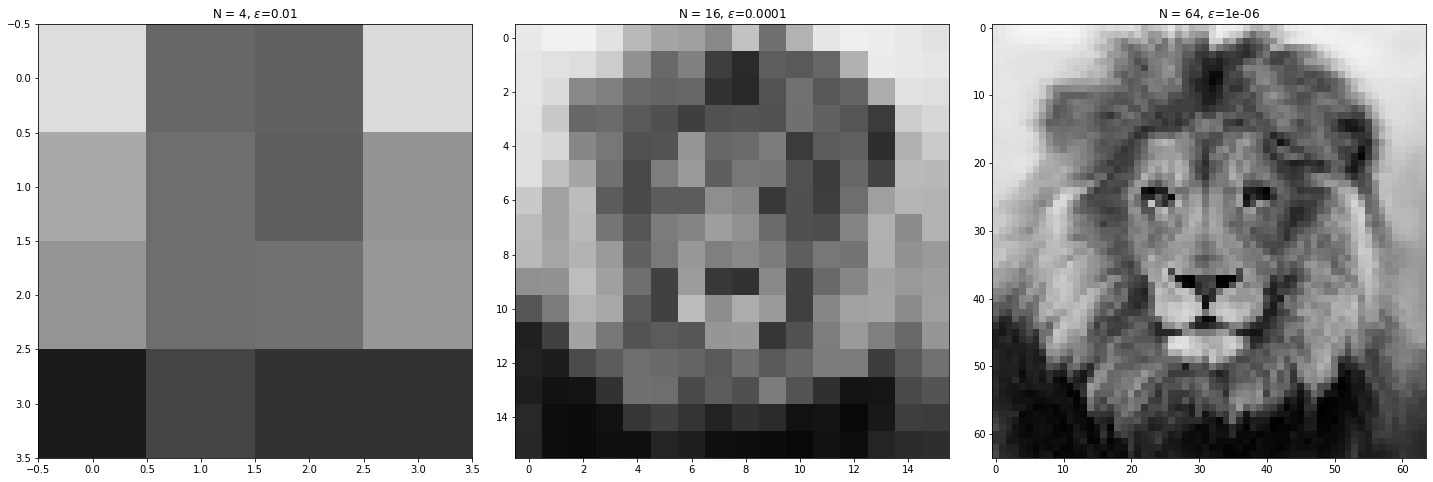

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
plt.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.1)


grey_image_float_array = grey_image_array/255
Lp_errors_array=np.zeros((8,6))
L1_optimal_errors=np.zeros(8)
N_values = [2**x for x in range(1,9)]
epsilon_values = [10**x for x in range(-1,-7,-1)]
k = 0
for i, N in enumerate(N_values):
  for j, epsilon in enumerate(epsilon_values):
    quantization_approx, L1_approx_error_i_j = Lp_solver(grey_image_float_array, N, p=1, epsilon=epsilon, delta=0.001)
    Lp_errors_array[i][j] = L1_approx_error_i_j
    if ((i==1 and j==1) or (i==3 and j==3) or (i==5 and j==5)):
      #printing choice sampled images
      ax[k].imshow(quantization_approx, cmap='gray', vmin=0, vmax=1)
      ax[k].set_title(f"N = {N}, $\epsilon$={epsilon}")
      k += 1
  quantized_image, L1_optimal_error = L1_solver(grey_image_float_array,int(N))
  L1_optimal_errors[i] = L1_optimal_error

In [77]:
Lp_errors_df = pd.DataFrame(Lp_errors_array, columns=epsilon_values, index=N_values)
Lp_errors_df

,0.100000,0.010000,0.001000,0.000100,0.000010,0.000001
2,0.202720,0.203921,0.204651,0.205581,0.204521,0.207229
4,0.144331,0.144890,0.145818,0.146045,0.146383,0.146254
8,0.105977,0.106240,0.107303,0.107204,0.107772,0.107317
16,0.084143,0.084748,0.085336,0.085796,0.085710,0.086179
32,0.066696,0.067195,0.067964,0.068538,0.068757,0.068436
64,0.052937,0.053394,0.054173,0.053796,0.053986,0.054194
128,0.041221,0.040975,0.041242,0.041377,0.042217,0.042237
256,0.028590,0.027881,0.027891,0.027917,0.027922,0.027922


In [78]:
print(L1_optimal_errors)

[0.2024498  0.14362029 0.10527453 0.08375653 0.06620548 0.05247774
 0.04043012 0.02781691]


### Section 5: Compare $L_4$ and $L_{3/2}$ approximation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in power
  del sys.path[0]


The L4 approximation error is 0.0019253739564406877


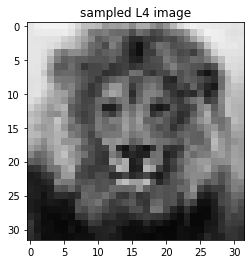

The L3/2 approximation error is 0.023391795179367177


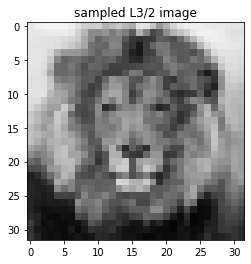

In [79]:
L4_approximation, L4_error = Lp_solver(grey_image_float_array, N=2**5 ,p=4 ,epsilon=0.00001 ,delta=0.001)
L3_2_approximation, L3_2_error = Lp_solver(grey_image_float_array, N=2**5 ,p=1.5 ,epsilon=0.00001 ,delta=0.001)
print("The L4 approximation error is " + str(L4_error))
plt.imshow(L4_approximation, cmap='gray', vmin=0, vmax=1)
plt.title("sampled L4 image")
plt.show()

print("The L3/2 approximation error is " + str(L3_2_error))
plt.imshow(L3_2_approximation, cmap='gray', vmin=0, vmax=1)
plt.title("sampled L3/2 image")
plt.show()

In [80]:
L4_err_array = np.zeros(8)
L3_2_err_array = np.zeros(8)

for i, N in enumerate(N_values):
  _, L4_error = Lp_solver(grey_image_float_array, N=N, p=4, epsilon=0.00001, delta=0.005)
  _, L3_2_error = Lp_solver(grey_image_float_array, N=N, p=1.5, epsilon=0.00001, delta=0.005)
  L4_err_array[i] = L4_error
  L3_2_err_array[i] = L3_2_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in power
  del sys.path[0]


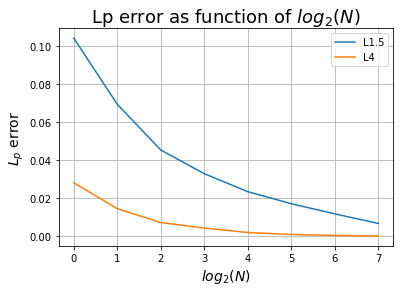

In [81]:
plt1, = plt.plot(range(0,8), L3_2_err_array, label = 'L1.5')
plt2, = plt.plot(range(0,8), L4_err_array, label = 'L4')
plt.title("Lp error as function of $log_2(N)$", fontsize=18)
plt.grid()
plt.xlabel("$log_2(N)$", fontsize = 14)
_ = plt.ylabel("$L_p$ error", fontsize = 14)
plt.legend(handles = [plt1, plt2])
plt.show()